<font color="red" size=4>Kaggle competition **Tabular Playground Series - May 2022** final solution kernel</font>
- May 2022 PLayground competition was binary classificationbased on tabular data, 
- My personal goal was to evaluate two implementations of neutal network dedicated to solve tabular data problems
> - the first TabNet implementation was based on Tensorflow framework
> - the second - Torch framework
- I was interested in several aspects of comparison, but especially:
> - the results in comparison with my favourite tools used for this kind of problem 
<br>(one of gradient boosting solutions (XGBoost/LightGBM/CatBoost))
> - the comparison working speed of Tensorflow and Torch implmentation

Theere were train data composed of 900 000 records and test data (700 000).
The features were:
- in some part numerical (float and continuous), 
- in come - categorical (with 2 to 16 levels) 
- one more complex feature, 30 of them all over.

This script contains the final solution, composed of traiing and prediction using:
1. Tensorflow TabNet implementation
2. PyTorch TabNet implementation
3. XGB, LightGBM and CatBoost implementation

The final conclusion is:
- **On overall, any of tested TabNet implementation performs better than boosters**
- **The price of this performance improvement one must accept to pay**  is much longer time of neural based solution training 

The final score I achieved during the competition was 0.99810 in comparison to 0.99833 winning value

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']="1"
import numpy as np
import pandas as pd
import itertools
import warnings
import lightgbm
import sklearn
import xgboost
import catboost
import matplotlib.ticker as ticker
import datetime as dt
from tabulate import tabulate
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from tabnet.models.classify import TabNetClassifier as TFTabnetClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tabnet.schedules import DecayWithWarmupSchedule
from tensorflow.keras.callbacks import Callback
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from pytorch_tabnet.tab_model import TabNetClassifier as TorchTabnetClassifier
import torch
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

for m in [pd,sklearn,xgboost, catboost, lightgbm, tf, torch]:
    print(f"{m.__name__}: {m.__version__}")
    
pd.options.display.max_columns=0
warnings.filterwarnings('ignore')

2022-06-03 18:17:03.752237: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


pandas: 1.4.2
sklearn: 1.0.2
xgboost: 1.6.0
catboost: 1.0.5
lightgbm: 3.3.2
tensorflow: 2.4.0
torch: 1.10.1+cu102


# Data preparation

## Loading

In [13]:
# Oryginal Kaggle csv converted to pickle to save space
# visit https://www.kaggle.com/competitions/tabular-playground-series-may-2022/data

SRCTRAIN="/mnt/workdata/_WORK_/Kaggle_202005_Tab/Data/oryginal/pkl/train.pkl"
SRCTEST="/mnt/workdata/_WORK_/Kaggle_202005_Tab/Data/oryginal/pkl/test.pkl"

train_df = pd.read_pickle(SRCTRAIN)
test_df = pd.read_pickle(SRCTEST)

df=train_df.append(test_df)
target=df['target']
df=df.iloc[:,:-1]

In [14]:
train_df.head()


,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,3,3,3,1,6,1,0,7,4,0.298218,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,0,2,3,0,1,0,4,6,0,-3.147667,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,6,6,4,3,1,2,2,1,4,2.820733,-3.485342,-0.784235,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,0,1,6,4,2,3,3,0,3,1.081084,-2.100177,-2.343819,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,4,3,0,6,0,3,3,1,0,-0.126179,0.605033,1.133665,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


## F27 decomposition

### Pattern distance

In [15]:
z_distance_data_cols = [f"f_27_{i+1}" for i in range(10)]
z_distance_data = pd.DataFrame(df['f_27'].apply(list).tolist(), columns=z_distance_data_cols)
for feature in z_distance_data_cols:
    z_distance_data[feature] = z_distance_data[feature].apply(lambda x: ord('Z') - ord(x))
z_distance_data.head()

,f_27_1,f_27_2,f_27_3,f_27_4,f_27_5,f_27_6,f_27_7,f_27_8,f_27_9,f_27_10
0,25,24,25,24,22,25,22,24,25,24
1,25,23,25,23,23,25,22,23,21,24
2,25,25,25,21,25,24,23,15,25,22
3,24,22,24,24,25,25,23,24,23,24
4,24,22,24,23,24,24,23,18,20,21


In [16]:
df=df.join(z_distance_data)

## Other features

In [17]:
df['f_27_uc'] = df['f_27'].apply(lambda x : len(set(x)))


## Interaction features

In [18]:
df["f_02_f_21_sum_hist"] = df.apply(lambda r: 1 if (r['f_02']+r['f_21'])<-5.3 else 2 if (r['f_02']+r['f_21'])>5.2 else 0, axis=1)
df["f_05_f_22_sum_hist"] = df.apply(lambda r: 1 if (r['f_05']+r['f_22'])<-5.4 else 2 if (r['f_05']+r['f_22'])>5.1 else 0, axis=1)
df["f_00_01_26"] = df.apply(lambda r: 2 if (r['f_00']+r['f_01']+r["f_26"])<-5 else 1 if (r['f_00']+r['f_01']+r["f_26"])>5 else 0 , axis=1)

## Final dataset

In [19]:
df=df.join(target)
del df['f_27']

In [20]:
print(df.shape)
df.head()

(1600000, 45)


,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,f_27_1,f_27_2,f_27_3,f_27_4,f_27_5,f_27_6,f_27_7,f_27_8,f_27_9,f_27_10,f_27_uc,f_02_f_21_sum_hist,f_05_f_22_sum_hist,f_00_01_26,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,3,3,3,1,6,1,0,7,4,0.298218,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,67.609153,0,0,25,24,25,24,22,25,22,24,25,24,3,0,0,0,0.0
1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,0,2,3,0,1,0,4,6,0,-3.147667,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,377.096415,0,0,25,23,25,23,23,25,22,23,21,24,5,0,0,0,1.0
2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,6,6,4,3,1,2,2,1,4,2.820733,-3.485342,-0.784235,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,-195.599702,0,2,25,25,25,21,25,24,23,15,25,22,6,0,0,0,1.0
3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,0,1,6,4,2,3,3,0,3,1.081084,-2.100177,-2.343819,0.572594,-1.653213,1.686035,-2.533098,-0.608601,210.826205,0,0,24,22,24,24,25,25,23,24,23,24,4,0,0,0,1.0
4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,4,3,0,6,0,3,3,1,0,-0.126179,0.605033,1.133665,-3.912929,-1.430366,2.127649,-3.306784,4.371371,-217.211798,0,1,24,22,24,23,24,24,23,18,20,21,6,0,0,1,1.0


In [21]:
train_df=df.loc[pd.isna(df['target'])==False,:]
train_df['target']=train_df['target'].astype(int)
test_df=df.loc[pd.isna(df['target'])==True,:].iloc[:,:-1]
print(train_df.shape)
print(test_df.shape)

(900000, 45)
(700000, 44)


## Data crossvalidation

In [4]:
CV_DATA='crossvalidated_10_dataset.pkl'
if os.path.isfile(CV_DATA):
    print(f'Loading crossvalidated data from {CV_DATA}')
    with open(CV_DATA, "rb") as f:
        folds = pickle.load(f)


Loading crossvalidated data from crossvalidated_10_dataset.pkl


# Tabnet Torch prediction

- Tabnet Torch implementation by DreamQuark-ai <a href=https://github.com/dreamquark-ai/tabnet>TabNet : Attentive Interpretable Tabular Learning </a>
- Paper: <a href=https://arxiv.org/ftp/arxiv/papers/2104/2104.13638.pdf>PyTorch Tabular: A Framework for Deep Learning with Tabular Data</a>

## Params definition

In [5]:
# The parameters were determined using 40 iterations of simulated anneal algorithm

params = {
  "max_epochs": 1000,
  "validation_fraction": 0.1,
  "early_stopping_rounds": 10,
  "tabnet_nd_na": 72,
  "tabnet_n_steps": 4,
  "tabnet_gamma": 1,
  "tabnet_n_independent": 3,
  "tabnet_n_shared": 3,
  "tabnet_momentum": 0.13130658137495604,
  "lambda_sparse": 0.005663888055050842,
  "tabnet_optimizer_lr": 0.015288556896304952,
  "tabnet_mask_type": "entmax",
  "pretraining_ratio": 0.5138208657762862,
  "batch_size": 4096
}

## CV folds training

In [6]:
# to use results for stacking or blending
# define placeholders for validation data predictions and test data predictions
folds_results_t = dict()
test_predictions_t=dict()
val_predictions_t=dict()
folds_scores_t={}

### Training loop

In [7]:
N_ATTEMPTS_PER_FOLD=1
start=dt.datetime.now()
for idx in folds.keys():
    print(f"Starting fold {idx}")
    ss = StandardScaler()
    X_train_fold_scaled = pd.DataFrame(ss.fit_transform(folds[idx]['X_train']), 
                                       index=folds[idx]['X_train'].index, 
                                       columns=folds[idx]['X_train'].columns)
    X_val_fold_scaled = pd.DataFrame(ss.transform(folds[idx]['X_val']), 
                                     index=folds[idx]['X_val'].index, 
                                     columns=folds[idx]['X_val'].columns)  
    
    for attempt in range(N_ATTEMPTS_PER_FOLD):
        
        print(f"Starting attempt {attempt} in fold {idx}")
        CHECKPOINTS_PATH=f"tabnettorch_checkpoints/{idx}_{attempt}/"

        model =  TorchTabnetClassifier(
            n_d = params['tabnet_nd_na'],
            n_a = params['tabnet_nd_na'],
            n_steps = params['tabnet_n_steps'],
            gamma = params['tabnet_gamma'],
            n_independent= params['tabnet_n_independent'],
            n_shared = params['tabnet_n_shared'],
            momentum = params['tabnet_momentum'],
            lambda_sparse = params['lambda_sparse'],
            optimizer_fn = torch.optim.Adam,
            optimizer_params={'lr':params['tabnet_optimizer_lr']},
            mask_type = params['tabnet_mask_type']
        )        

        model.fit(
            X_train_fold_scaled.values, folds[idx]['y_train'],
            eval_set=[(X_val_fold_scaled.values, folds[idx]['y_val'])],
            batch_size=params['batch_size'],
            virtual_batch_size=128,
            max_epochs=params['max_epochs'],
            patience=params['early_stopping_rounds']
        )
        
        folds_results_t[((idx, attempt), 'TabNetTorch')]= model.predict_proba(X_val_fold_scaled.values)[:,1]
        fold_auc = roc_auc_score(folds[(idx)]['y_val'], folds_results_t[((idx, attempt), 'TabNetTorch')])
        folds_scores_t[(idx, attempt)]=fold_auc
        print(f"Final fold-attempt result: {fold_auc:.6f}\n\n")    
        model.save_model(path=CHECKPOINTS_PATH+"torch_clf.zip")

    print("Performed fold {} attempt {}".format(idx, attempt))
print(f"Performed in {dt.datetime.now()-start}")

Starting fold 0
Starting attempt 0 in fold 0
Device used : cuda
epoch 0  | loss: 0.38257 | val_0_auc: 0.9812  |  0:00:26s
epoch 1  | loss: 0.16924 | val_0_auc: 0.9908  |  0:00:53s
epoch 2  | loss: 0.12901 | val_0_auc: 0.99398 |  0:01:20s
epoch 3  | loss: 0.1115  | val_0_auc: 0.9952  |  0:01:47s
epoch 4  | loss: 0.09986 | val_0_auc: 0.9961  |  0:02:14s
epoch 5  | loss: 0.09239 | val_0_auc: 0.99612 |  0:02:40s
epoch 6  | loss: 0.09844 | val_0_auc: 0.99382 |  0:03:07s
epoch 7  | loss: 0.09905 | val_0_auc: 0.99657 |  0:03:34s
epoch 8  | loss: 0.10452 | val_0_auc: 0.99571 |  0:04:01s
epoch 9  | loss: 0.09243 | val_0_auc: 0.99697 |  0:04:28s
epoch 10 | loss: 0.08391 | val_0_auc: 0.99716 |  0:04:55s
epoch 11 | loss: 0.08828 | val_0_auc: 0.99686 |  0:05:22s
epoch 12 | loss: 0.08173 | val_0_auc: 0.99699 |  0:05:47s
epoch 13 | loss: 0.08667 | val_0_auc: 0.99698 |  0:06:12s
epoch 14 | loss: 0.0791  | val_0_auc: 0.99709 |  0:06:39s
epoch 15 | loss: 0.08103 | val_0_auc: 0.99736 |  0:07:05s
epoch 16

In [27]:
torch_tabnet_res__={
    "folds_scores": folds_scores_t,
    "folds": folds,
    "folds_val_predictions": folds_results_t,
}
with open("TorchTabNetResults.pkl", "wb") as f:
    pickle.dump(torch_tabnet_res__,f)

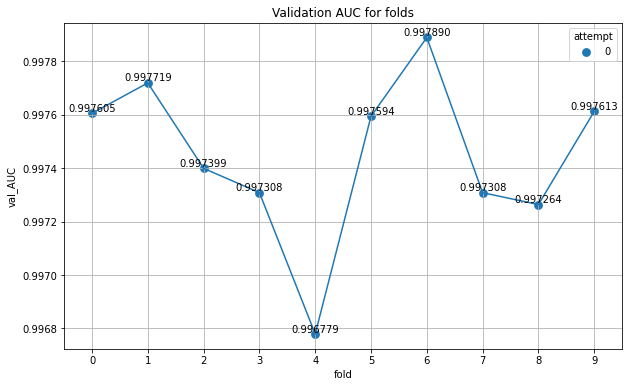

In [10]:
score_df=pd.DataFrame.from_dict(folds_scores_t, orient='index', columns=['val_AUC'])
score_df=score_df.reset_index()
score_df['fold']=score_df['attempt']=np.NaN
score_df['fold']=score_df['index'].apply(lambda x: x[0])
score_df['attempt']=score_df['index'].apply(lambda x: x[1])
score_df.sort_values(by=['fold','attempt']).reset_index()
score_df=score_df[['fold','attempt','val_AUC']]
fig,ax=plt.subplots(1,1,figsize=(10,6))
sns.lineplot(data=score_df, x='fold', y='val_AUC',  ax=ax, err_style='bars')
score_df_best = score_df.loc[score_df.groupby('fold')['val_AUC'].idxmax()]
sns.pointplot(data=score_df_best, x='fold', y='val_AUC', hue='attempt', linestyles='', ax=ax)
for idx, fold, val in list(score_df_best[['fold', 'val_AUC']].itertuples()):
    ax.text(fold, val, f"{val:.6f}", horizontalalignment='center', verticalalignment='bottom')
    
ax.grid('both')
ax.set_title('Validation AUC for folds');


In [11]:
# some iterations here were performed in the other script
# tyhe mean value is only for folds 0-6
score_df=pd.DataFrame.from_dict(folds_scores_t, orient='index')
print(f'Mean AUC: {score_df.mean()[0]:.6f} +/- {score_df.std()[0]:.6f}')


Mean AUC: 0.997448 +/- 0.000310


In [22]:

test_predictions=dict()
for idx in tqdm(folds.keys()):
    CHECKPOINTS_PATH=f"tabnettorch_checkpoints/{idx}_{attempt}/"
    model_tabnet_torch = TorchTabnetClassifier()
    model_tabnet_torch.load_model(CHECKPOINTS_PATH+"torch_clf.zip.zip")
    ss.fit(folds[idx]['X_train'])
    x_val_fold_scaled=ss.transform(folds[idx]['X_val'])
    folds_results_t[((idx, 0), 'TabNetTorch')]= model_tabnet_torch.predict_proba(x_val_fold_scaled)[:,1]
    
    test_df_=ss.transform(test_df)
    test_predictions[idx]=model_tabnet_torch.predict_proba(test_df_)[:,1]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Device used : cuda
Device used : cuda


 10%|████▍                                       | 1/10 [00:14<02:12, 14.74s/it]

Device used : cuda
Device used : cuda


 20%|████████▊                                   | 2/10 [00:29<01:56, 14.52s/it]

Device used : cuda
Device used : cuda


 30%|█████████████▏                              | 3/10 [00:43<01:41, 14.45s/it]

Device used : cuda
Device used : cuda


 40%|█████████████████▌                          | 4/10 [00:57<01:26, 14.40s/it]

Device used : cuda
Device used : cuda


 50%|██████████████████████                      | 5/10 [01:11<01:11, 14.30s/it]

Device used : cuda
Device used : cuda


 60%|██████████████████████████▍                 | 6/10 [01:26<00:57, 14.35s/it]

Device used : cuda
Device used : cuda


 70%|██████████████████████████████▊             | 7/10 [01:40<00:43, 14.43s/it]

Device used : cuda
Device used : cuda


 80%|███████████████████████████████████▏        | 8/10 [01:55<00:28, 14.47s/it]

Device used : cuda
Device used : cuda


 90%|███████████████████████████████████████▌    | 9/10 [02:09<00:14, 14.43s/it]

Device used : cuda
Device used : cuda


100%|███████████████████████████████████████████| 10/10 [02:24<00:00, 14.46s/it]


<AxesSubplot:>

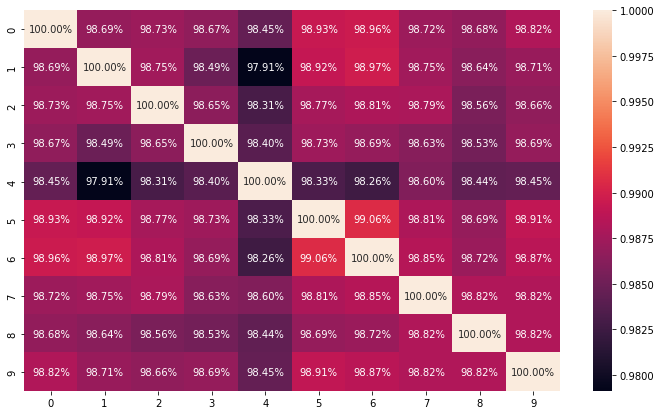

In [23]:
test_pred_df = pd.DataFrame(test_predictions)
fig,ax=plt.subplots(1,1,figsize=(12,7))
sns.heatmap(test_pred_df.corr(), annot=True, fmt=".2%")


## Mean prediction using all data

In [24]:
with open("TorchTabNetResults_test_preds_1.pkl", "wb") as f:
    pickle.dump(test_predictions, f)

In [26]:
res_=pd.DataFrame(test_pred_df.mean(axis=1),  columns=['target'])
res_. index=test_df.index
res_.to_csv("Finalsolution_data30_TorchTabNet_1.csv")

The result obtained is 0.99810 (Public), 0.99807 (Private)